In [1]:
import glob, os, sys
import uproot, ROOT
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, roc_auc_score, auc
sys.path.append("..")
from utils.utils import *

Welcome to JupyROOT 6.28/04


In [2]:
# def signal_cut(df_chunk):
#     cut1 = (df_chunk['IsTruthHadronic']==1)
#     cut2 = (df_chunk['n_subjets'] >=2)
#     cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
#     cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
#     return (cut1 & cut2 & cut3 & cut4)
    
# def bkg_cut(df_chunk):
#     cut1 = (df_chunk['n_subjets'] >=2)
#     cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
#     cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
#     return (cut1 & cut2 & cut3)

# def h52panda(filelist, xs, cut, bkg=0):
#     combined = pd.DataFrame()
#     chunk_size = 10000000  # Adjust this size to suit your system's memory
#     pt_bins = np.linspace(200000, 1000000, 41)

#     dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
#                 "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
#                 "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
#                 "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
#                 "d0_leadtrack_lead", "d0_leadtrack_subl",
#                 "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
#                 "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta"]

#     for index in range(len(filelist)):
#         file_path = filelist[index]
    
#         # Process the file in chunks
#         with h5py.File(file_path, 'r') as h5_file:
#             # Determine the total length of the datasets
#             total_length = h5_file[dataset_keys[0]].shape[0]
#             print(f'{filelist[index]}: {total_length}')
#             print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
#             # Read and process each chunk
#             for chunk_start in range(0, total_length, chunk_size):
#                 chunk_end = chunk_start + chunk_size

#                 # Use slicing to read a chunk from each dataset in the HDF5 file
#                 data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

#                 # Convert the dictionary to a pandas DataFrame
#                 df_chunk = pd.DataFrame(data)

#                 # Apply Cut
#                 filtered_chunk = df_chunk[cut(df_chunk)]
#                 filtered_chunk = filtered_chunk.copy()
#                 filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

#                 combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
#     combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
#     combined['label'] = bkg
#     combined['weight'] = combined['event_weight'] * combined['pT_weight']

#     return combined

# path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"

# bkg_xs = [364701, 364702, 364703, 364704, 364705, 364706, 364707, 364708, 364709, 364710, 364711, 364712]
# signal_xs = [425108, 425100, 425101, 425102, 425103, 425104, 425105, 425106, 425107, 425200]
# # gamma_xs = [425200]

# # File Location. order maatch XS. 
# bkg_filelist = []
# for index in range(12):
#     bkg_filelist.append(path+f"jz_w_newbdt/dijet_flattened_jz{index}.h5")
# print(bkg_filelist)

# # signal_filelist = [path+"signal_w_newbdt/graviton_flattened_M1000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M1500.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M1750.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2250.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M2500.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M3000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M4000.h5",
# #                 path+"signal_w_newbdt/graviton_flattened_M5000.h5",
# #                 path+"signal_w_newbdt/gamma_flattened_0.h5"]

# # combined_signal = h52panda(signal_filelist, signal_xs, signal_cut, 1)
# combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, 0)

# comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, 1)

In [3]:
def signal_cut(df_chunk):
    cut1 = (df_chunk['IsTruthHadronic']==1)
    cut2 = (df_chunk['n_subjets'] >=2)
    cut3 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut4 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    return (cut1 & cut2 & cut4)
    
def bkg_cut(df_chunk):
    cut1 = (df_chunk['n_subjets'] >=2)
    cut2 = ((df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6))
    cut3 = (((df_chunk['n_tracks_lead'] == 1) | (df_chunk['n_tracks_lead'] == 3)) & ((df_chunk['n_tracks_subl'] == 1) | (df_chunk['n_tracks_subl'] == 3)))
    # cut4 = (df_chunk['event_weight'] < 1000)
    return (cut1 & cut3)

def h52panda(filelist, xs, cut, bkg=0):
    combined = pd.DataFrame()
    chunk_size = 10000000  # Adjust this size to suit your system's memory
    pt_bins = np.linspace(200000, 1000000, 41)

    dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score", "bdt_score_new", "average_mu", "eta", "lead_subjet_pt", "sublead_subjet_pt"]
    track_data_keys = ['charge']

    for index in range(len(filelist)):
        file_path = filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')
            print(len(h5_file["d0_leadtrack_subl"]), len(h5_file["lead_subjet_pt"]), len(h5_file["trackPt"]))
            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

                # Convert the dictionary to a pandas DataFrame
                df_chunk = pd.DataFrame(data)

                filtered_chunk = df_chunk

                filtered_chunk = filtered_chunk.copy()
                print("XS: ", getXS(xs[index]) )
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index]) 

                # Apply Cut
                filtered_chunk = filtered_chunk[cut(filtered_chunk)]

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])
    combined['label'] = bkg
    combined['weight'] = combined['event_weight'] * combined['pT_weight']

    return combined

path = "/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/"

mc23_jz_xs = [801165, 801166, 801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]
# mc23_jz_xs = [801167, 801168, 801169, 801170, 801171, 801172, 801173, 801174]

# File Location. order maatch XS. 
bkg_filelist = []
for index in range(10):
    bkg_filelist.append(path+f"ntuple_flattened_v2_jz{index}.h5")

print(bkg_filelist)
combined_bkg = h52panda(bkg_filelist, mc23_jz_xs, bkg_cut, 0)

comb_vh_signal = h52panda([path+"ntuple_flattened_VHtautau.h5"], [802168], signal_cut, 1)

print(len(combined_bkg), len(comb_vh_signal))

['/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz0.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz1.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz2.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz3.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz4.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz5.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz6.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz7.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz8.h5', '/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz9.h5']
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_

XS:  25995496.038000003
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz3.h5: 190882
190882 190882 943105
XS:  339703.43616
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz4.h5: 377102
377102 377102 1842047
XS:  3851.939007
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz5.h5: 118257
118257 118257 555498
XS:  77.79959475199999
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz6.h5: 50425
50425 50425 236598
XS:  3.0215374215000006
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz7.h5: 26110
26110 26110 122405
XS:  0.23829709869000001
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz8.h5: 20999
20999 20999 97417
XS:  0.0094199304656
/global/u2/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/ntuple_flattened_v2_jz9.h5: 14181
14181 14181 66587
XS:  0.00042597234786
/global/u2/a/

In [5]:
combined_bkg

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,event_weight,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,pT_weight,label,weight
0,10085719,300596.031250,0,0.841778,0.098343,0.049672,0.870744,0.022996,0.183503,0.188156,...,4.258413e+06,0.383750,0.003208,28.500000,-0.293797,283448.437500,17147.587891,2.347177e-07,0,9.995250e-01
1,12932274,216630.718750,0,0.794682,0.629580,0.237235,0.720417,0.022866,0.023344,0.103682,...,4.452275e+04,0.508101,0.056426,52.500000,-1.207046,145293.812500,71336.898438,2.194466e-05,0,9.770365e-01
2,17175243,273065.281250,0,0.777353,0.152971,0.034437,0.828344,0.093140,0.020684,0.129106,...,1.474182e+05,0.474229,0.006495,52.500000,-1.601396,261713.062500,11352.231445,6.713848e-06,0,9.897431e-01
3,3612531,222817.734375,0,0.822131,0.329967,0.044670,0.718734,0.031373,0.062170,0.131811,...,3.664807e+04,0.387727,0.002754,59.500000,1.255504,208969.484375,13848.255859,2.635199e-05,0,9.657497e-01
4,2712131,345894.031250,0,0.899058,0.197741,0.053103,0.884523,0.004823,0.186105,0.141177,...,6.951111e+03,0.525784,0.010974,55.500000,-0.167395,325128.031250,20766.005859,1.389082e-04,0,9.655662e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147045,3530301,635523.687500,0,0.976511,0.048994,0.021377,0.935853,0.072714,0.190492,0.158996,...,1.482139e-09,0.486474,0.007877,50.500000,0.381586,621006.937500,14516.732422,1.000000e+00,0,1.482139e-09
1147046,3595731,356667.031250,0,0.781185,0.384102,0.031842,0.769184,0.005765,0.105419,0.160508,...,9.003522e-10,0.518013,0.022116,57.499996,1.245879,341901.968750,14765.076172,1.389082e-04,0,1.250663e-13
1147047,4379,369941.406250,0,0.957363,0.942135,0.030947,0.872426,0.015484,0.095864,0.142223,...,1.067854e-09,0.535789,0.073513,41.500000,0.392969,356818.531250,13122.860352,7.117438e-03,0,7.600384e-12
1147048,17390,521755.187500,0,0.871930,0.551868,0.017936,0.635051,0.001772,0.100478,0.047001,...,1.049249e-09,0.627198,0.116632,41.499996,-0.270125,507019.375000,14735.801758,2.222222e-01,0,2.331664e-10


In [7]:
# combined_bkg.to_csv(path+'combined_bkg_inc.csv', index=False)
# combined_signal.to_csv(path+'combined_signal_inc_2.csv', index=False)

In [4]:
comb_vh_signal.to_csv(path+'vhtautau_ntuple_inc_no_pt_cut.csv', index=False)
combined_bkg.to_csv(path+'combined_jz_ntuple_inc_no_pt_cut.csv', index=False)


In [18]:
# old_vh = pd.read_csv('/global/u2/a/agarabag/pscratch/ditdau_samples/vhtautau_ntuple_inc.csv')
# new_vh = pd.read_csv('/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/vhtautau_ntuple_inc.csv')
new_jz = pd.read_csv('/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn/combined_jz_ntuple_inc.csv')

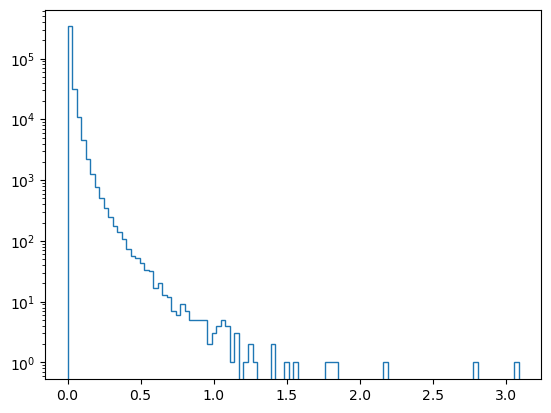

In [58]:
#plot event_weight feature for events with ditau_pt less than 0.4*1e6
e_weigt_cut = combined_bkg[(combined_bkg['ditau_pt'] < 0.4*1e6) & (combined_bkg['event_weight'] < 10)]
plt.hist(e_weigt_cut['event_weight'], bins=100, histtype='step', label='ditau_pt < 0.4*1e6')
plt.yscale('log')
plt.show()

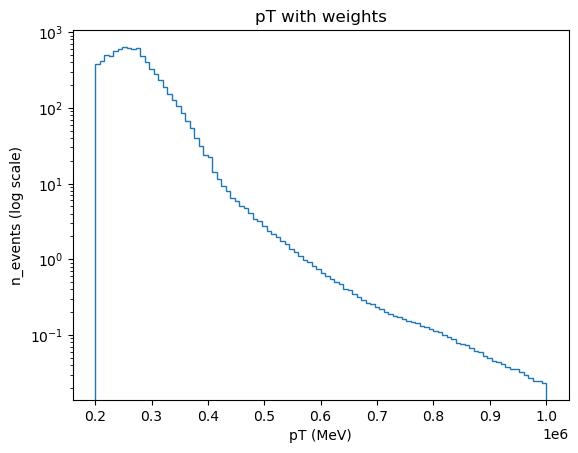

In [72]:
combined_bkg_n = combined_bkg
#filter events with event_weight biogger than 4*1e6
# combined_bkg_n = combined_bkg_n[combined_bkg_n.f_core_subl != -999]

# combined_bkg_n = combined_bkg_n[combined_bkg_n['event_weight'] < 100]

plt.hist(combined_bkg_n['ditau_pt'], bins=100, weights=combined_bkg_n['event_weight'], histtype='step')
plt.yscale('log')
plt.xlabel('pT (MeV)')
plt.ylabel('n_events (log scale)')
plt.title('pT with weights')
plt.show()


In [11]:
new_vh

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,event_weight,bdt_score,bdt_score_new,average_mu,eta,lead_subjet_pt,sublead_subjet_pt,pT_weight,label,weight
0,12555601,558046.94,1,0.838201,0.608886,0.038208,0.934904,0.012090,0.011722,0.105588,...,1.464964e-11,0.476975,0.038720,30.499998,1.756925,535240.60,22806.318,6.927786e+05,1,1.014896e-05
1,12555614,332695.50,1,0.957708,0.971556,0.465595,0.952943,0.023228,0.006680,0.002029,...,3.292607e-12,0.806928,0.997562,31.499998,-0.243091,170144.80,162550.690,5.095433e+04,1,1.677726e-07
2,12555609,769958.44,1,0.853378,0.681585,0.117519,0.965499,0.001520,0.022779,0.012782,...,2.805640e-12,0.741454,0.983310,31.499998,0.163657,676240.00,93718.414,6.082985e+06,1,1.706666e-05
3,12555613,382315.34,1,0.895560,0.735587,0.279744,0.944598,0.000000,0.007320,0.014492,...,8.499624e-11,0.790094,0.993908,30.499998,-0.160401,269092.20,113223.150,1.092424e+05,1,9.285193e-06
4,12555608,501504.28,1,0.967970,0.744627,0.197106,0.902076,0.000000,0.147490,0.190992,...,6.324896e-12,0.550149,0.176463,31.499998,0.624289,391924.00,109580.280,4.506018e+05,1,2.850009e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842177,13197187,431976.44,1,0.951974,0.873579,0.185070,0.846039,0.011745,0.009147,0.011547,...,3.150254e-12,0.769205,0.986443,65.500000,1.014485,337482.25,94494.195,1.781179e+05,1,5.611166e-07
4842178,13197197,506210.80,1,0.922233,0.691846,0.057907,0.892159,0.003076,0.018185,0.057121,...,2.068809e-12,0.655302,0.757044,66.500000,-0.262314,473354.38,32856.420,4.506018e+05,1,9.322092e-07
4842179,13197190,839142.60,1,0.871092,0.921659,0.264379,0.937399,0.000000,0.010120,0.011831,...,7.508517e-13,0.785865,0.987781,66.500000,0.752680,602475.40,236667.230,1.035244e+07,1,7.773145e-06
4842180,13197200,341988.47,1,0.785581,0.929359,0.413273,0.837190,0.014225,0.021818,0.017692,...,2.391564e-10,0.759621,0.993915,67.500000,1.373492,173168.30,168820.170,6.556927e+04,1,1.568131e-05


In [12]:
old_vh

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,n_tracks_subl,n_subjets,event_weight,bdt_score,bdt_score_new,average_mu,eta,pT_weight,label,weight
0,14396808,634033.40,1,0.932689,0.877706,0.207235,0.975947,0.000000,0.012776,0.019256,...,1,2,5.647279e-15,0.801027,0.997562,31.499998,-1.418528,8.851637e+08,1,4.998766e-06
1,14396806,375350.90,1,0.934633,0.899379,0.280198,0.957487,0.000000,0.005520,0.015002,...,1,2,8.142706e-16,0.762409,0.997562,31.499998,0.523904,4.742845e+07,1,3.861959e-08
2,14396802,427300.28,1,0.992362,0.896720,0.458971,0.990874,0.003605,0.002031,0.007232,...,1,2,4.841856e-15,0.760855,0.997562,30.499998,0.397308,9.923418e+07,1,4.804776e-07
3,14396809,920147.80,1,0.961460,0.964794,0.187952,0.965863,0.001104,0.001343,0.025407,...,1,2,3.202030e-15,0.726551,0.988675,31.499998,0.345424,1.350129e+10,1,4.323155e-05
4,14396814,403815.70,1,0.852629,0.927708,0.052375,0.948476,0.000000,0.007829,0.027787,...,1,2,9.958147e-14,0.780486,0.987474,33.500000,-1.323981,7.732965e+07,1,7.700600e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842177,19757187,724790.90,1,0.162797,0.899614,0.331564,0.933597,0.000000,0.162095,0.009045,...,1,2,6.404206e-15,0.731405,0.934517,65.500000,0.012346,2.333336e+09,1,1.494316e-05
4842178,19757193,314465.34,1,0.916516,0.830618,0.085293,0.846950,0.002984,0.003086,0.044975,...,1,2,7.989616e-14,0.782917,0.964848,65.500000,0.803929,2.208382e+07,1,1.764412e-06
4842179,19757190,418932.22,1,0.902801,0.529068,0.036525,0.890997,0.007241,0.024812,0.044089,...,1,2,8.332273e-15,0.716185,0.433024,65.500000,0.273038,7.732965e+07,1,6.443318e-07
4842180,19757180,271560.88,1,0.910954,0.839131,0.163198,0.770855,0.040240,0.001992,0.040336,...,3,3,9.812965e-15,0.689027,0.993599,65.500000,-0.165951,2.333839e+07,1,2.290188e-07


In [20]:
path = "/global/u2/a/agarabag/pscratch/ditdau_samples/"
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_signal.csv')

In [21]:
signal_scores = combined_signal['bdt_score']
print(np.sum(signal_scores > 0.72) / len(signal_scores))

0.7532474177570986


In [22]:
signal_scores = combined_signal['bdt_score_new']
print(np.sum(signal_scores > 0.957) / len(signal_scores))

0.7564914243610911


In [12]:
signal_scores = combined_signal['bdt_score_new']
print(np.sum(signal_scores > 0.986) / len(signal_scores))

0.5449044194899644


In [13]:
bkg = combined_bkg['bdt_score_new']
print(np.sum(bkg > 0.01) / len(bkg))

0.5521729938552566


In [5]:
bkg = combined_bkg['bdt_score']
print(np.sum(bkg > 0.55) / len(bkg))

0.2534350073811213


In [18]:
signal_scores = combined_signal['inc_new_bdt'][combined_signal['inc_new_bdt'] > 0]
print(np.sum(signal_scores > 0.957) / len(signal_scores))

0.7279085574271217


In [19]:
bkg = combined_bkg['inc_new_bdt'][combined_bkg['inc_new_bdt'] > 0]
print(np.sum(bkg > 0.045) / len(bkg))

0.25100196644043676


In [38]:
len(combined_bkg), len(combined_signal)

(2180563, 293156)

In [5]:
len(pd.read_csv(path+'combined_bkg_inc_new.csv'))


2180563

In [23]:
import pandas as pd

class DataFrameCuts:
    def __init__(self, df_bkg, df_signal):
        self.df_bkg = df_bkg
        self.df_signal = df_signal

    def apply_cut(self, df, cut_condition):
        return df[cut_condition]

    def cut4(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 3)) | ((df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 1)))

    def cut5(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 1) & (df['n_tracks_subl'] == 1))

    def cut6(self, df):
        return self.apply_cut(df, (df['n_tracks_lead'] == 3) & (df['n_tracks_subl'] == 3))

    def cut7(self, df):
        return self.apply_cut(df, ((df['n_tracks_lead'] == 1) | (df['n_tracks_lead'] == 3)) & ((df['n_tracks_subl'] == 1) | (df['n_tracks_subl'] == 3)))

    def process(self):
        self.combined_bkg_1p3p = self.cut4(self.df_bkg)
        self.combined_bkg_1p1p = self.cut5(self.df_bkg)
        self.combined_bkg_3p3p = self.cut6(self.df_bkg)

        self.combined_signal_1p3p = self.cut4(self.df_signal)
        self.combined_signal_1p1p = self.cut5(self.df_signal)
        self.combined_signal_3p3p = self.cut6(self.df_signal)


        return {
            'bkg': {
                '1p3p': self.combined_bkg_1p3p,
                '1p1p': self.combined_bkg_1p1p,
                '3p3p': self.combined_bkg_3p3p,
                'inc': self.df_bkg
            },
            'signal': {
                '1p3p': self.combined_signal_1p3p,
                '1p1p': self.combined_signal_1p1p,
                '3p3p': self.combined_signal_3p3p,
                'inc': self.df_signal
            }
        }

In [24]:
combined_bkg = pd.read_csv(path+'inc_bdt_bkg.csv')
combined_signal = pd.read_csv(path+'inc_bdt_vhtautau.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.72]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

# Accessing the results
combined_bkg_1p3p = combined['bkg']['1p3p']
combined_bkg_1p1p = combined['bkg']['1p1p']
combined_bkg_3p3p = combined['bkg']['3p3p']
combined_bkg_inc = combined['bkg']['inc']
combined_signal_1p3p = combined['bkg']['1p3p']
combined_signal_1p1p = combined['bkg']['1p1p']
combined_signal_3p3p = combined['bkg']['3p3p']
combined_signal_inc = combined['bkg']['inc']

combined_bkg_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_bkg_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_bkg_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_bkg_inc_bdt = combined_bdt['bkg']['inc']
combined_signal_1p3p_bdt = combined_bdt['bkg']['1p3p']
combined_signal_1p1p_bdt = combined_bdt['bkg']['1p1p']
combined_signal_3p3p_bdt = combined_bdt['bkg']['3p3p']
combined_signal_inc_bdt = combined_bdt['bkg']['inc']



In [27]:
combined

{'bkg': {'1p3p':          event_id   ditau_pt  IsTruthHadronic  f_core_lead  f_core_subl  \
  0        36079784  289045.94                0     0.894528     0.246616   
  3        35893734  248336.08                0     0.680812     0.653458   
  6        26917460  221883.73                0     0.882286     0.677054   
  9        32924154  208441.89                0     0.842463     0.460940   
  11       30846038  204277.62                0     0.904852     0.615187   
  ...           ...        ...              ...          ...          ...   
  2180550   1082150  252817.34                0     0.726470     0.277918   
  2180555   1284683  253029.23                0     0.669082     0.294558   
  2180557   1489518  298590.72                0     0.768915     0.246262   
  2180559   1110524  325928.28                0     0.757148     0.080900   
  2180561   1033696  290693.70                0     0.959796     0.055276   
  
           f_subjet_subl  f_subjets  f_isotracks  R_max_le

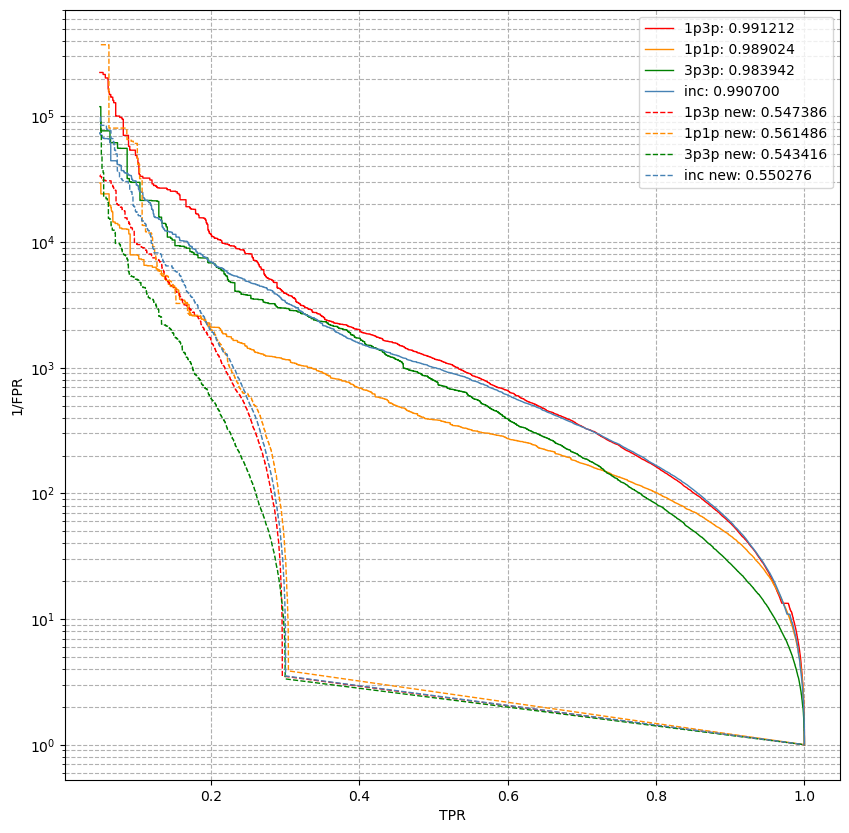

In [26]:
channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['inc_new_bdt'], combined['bkg'][channel[i]]['inc_new_bdt'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [8]:
''' Testing for Testing Data
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

def tmp(df):
    df['eventID_mod'] = df['event_id'] % 10
    train_df = df[df['eventID_mod'] < 7] # 70%
    test_df = df[df['eventID_mod'] >= 7] # 30%
    return test_df

combined_signal = tmp(combined_signal)
combined_bkg = tmp(combined_bkg)

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

channel = ['1p3p', '1p1p', '3p3p', 'inc']
color = ['red', 'darkorange', 'green', 'steelblue']

fig7 = plt.figure(figsize=(10, 10))
for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score'], combined['bkg'][channel[i]]['bdt_score'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f'{channel[i]}: {roc_auc:.6f}')

for i in range(4):
    fpr, tpr = calc_roc(combined['signal'][channel[i]]['bdt_score_new'], combined['bkg'][channel[i]]['bdt_score_new'], combined['signal'][channel[i]]['weight'], combined['bkg'][channel[i]]['weight'])
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], linestyle='dashed', label=f'{channel[i]} new: {roc_auc:.6f}')
             
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
'''

' Testing for Testing Data\ncombined_bkg = pd.read_csv(path+\'combined_bkg_inc.csv\')\ncombined_signal = pd.read_csv(path+\'combined_signal_inc.csv\')\n\ndef tmp(df):\n    df[\'eventID_mod\'] = df[\'event_id\'] % 10\n    train_df = df[df[\'eventID_mod\'] < 7] # 70%\n    test_df = df[df[\'eventID_mod\'] >= 7] # 30%\n    return test_df\n\ncombined_signal = tmp(combined_signal)\ncombined_bkg = tmp(combined_bkg)\n\ncuts_processor = DataFrameCuts(combined_bkg, combined_signal)\ncombined = cuts_processor.process()\n\nchannel = [\'1p3p\', \'1p1p\', \'3p3p\', \'inc\']\ncolor = [\'red\', \'darkorange\', \'green\', \'steelblue\']\n\nfig7 = plt.figure(figsize=(10, 10))\nfor i in range(4):\n    fpr, tpr = calc_roc(combined[\'signal\'][channel[i]][\'bdt_score\'], combined[\'bkg\'][channel[i]][\'bdt_score\'], combined[\'signal\'][channel[i]][\'weight\'], combined[\'bkg\'][channel[i]][\'weight\'])\n    roc_auc = auc(fpr, tpr)\n    plt.plot(tpr, 1/fpr, linewidth=1, color=color[i], label=f\'{channel[i]

In [49]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

%jsroot on
ROOT.gStyle.SetOptStat(0)
ROOT.gROOT.SetBatch(True)
canvas = ROOT.TCanvas("canvas", "eff_plots", 800, 500)
# canvas.cd()
# canvas.Print("eff_plots.pdf[")

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

pt_1p3p_eff_w, pt_1p1p_eff_w, pt_3p3p_eff_w, pt_inc_eff_w = plot_eff(bkg_pt_list, bkg_w_list, "DiJet pT", 20, 200000, 1000000, eta=False)
pt_1p3p_eff_w.SetMarkerStyle(22)
pt_1p1p_eff_w.SetMarkerStyle(22)
pt_3p3p_eff_w.SetMarkerStyle(22)
pt_inc_eff_w.SetMarkerStyle(22)
pt_1p3p_eff_w.Draw(" e")
pt_1p1p_eff_w.Draw("same e")
pt_3p3p_eff_w.Draw("same e")
pt_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [50]:
eta_1p3p_eff_w, eta_1p1p_eff_w, eta_3p3p_eff_w, eta_inc_eff_w = plot_eff(bkg_eta_list, bkg_w_list, "DiJet eta", 40, -2.5, 2.5, eta=True)
eta_1p3p_eff_w.SetMarkerStyle(22)
eta_1p1p_eff_w.SetMarkerStyle(22)
eta_3p3p_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetMarkerStyle(22)
eta_1p3p_eff_w.Draw(" e")
eta_1p1p_eff_w.Draw("same e")
eta_3p3p_eff_w.Draw("same e")
eta_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(eta_1p3p_eff_w, "1p3p")
legend.AddEntry(eta_1p1p_eff_w, "1p1p")
legend.AddEntry(eta_3p3p_eff_w, "3p3p")
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [51]:
eta_inc_eff_w.SetMarkerStyle(22)
eta_inc_eff_w.SetLineColor(ROOT.kBlue)
eta_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.8, 0.85, 0.9)
legend.AddEntry(eta_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

In [52]:
mu_1p3p_eff_w, mu_1p1p_eff_w, mu_3p3p_eff_w, mu_inc_eff_w = plot_eff(bkg_mu_list, bkg_w_list, "DiJet mu", 20, 18, 74, eta=False)
mu_1p3p_eff_w.SetMarkerStyle(22)
mu_1p1p_eff_w.SetMarkerStyle(22)
mu_3p3p_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetMarkerStyle(22)
mu_1p3p_eff_w.Draw(" e")
mu_1p1p_eff_w.Draw("same e")
mu_3p3p_eff_w.Draw("same e")
mu_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(mu_1p3p_eff_w, "1p3p")
legend.AddEntry(mu_1p1p_eff_w, "1p1p")
legend.AddEntry(mu_3p3p_eff_w, "3p3p")
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [53]:
mu_inc_eff_w.SetMarkerStyle(22)
mu_inc_eff_w.SetLineColor(ROOT.kBlue)
mu_inc_eff_w.Draw(" e")
legend = ROOT.TLegend(0.7, 0.7, 0.85, 0.85)
legend.AddEntry(mu_inc_eff_w, "inclusive")
legend.Draw()
canvas.Draw()


In [54]:
combined_bkg = pd.read_csv(path+'combined_bkg_inc.csv')
combined_signal = pd.read_csv(path+'combined_signal_inc.csv')

combined_bkg_bdt = combined_bkg[combined_bkg['bdt_score_new'] > 0.55]
combined_signal_bdt = combined_signal[combined_signal['bdt_score_new'] > 0.96]

cuts_processor = DataFrameCuts(combined_bkg, combined_signal)
combined = cuts_processor.process()

cuts_processor_bdt = DataFrameCuts(combined_bkg_bdt, combined_signal_bdt)
combined_bdt = cuts_processor_bdt.process()

class DataList:
    def __init__(self, combined, combined_bdt):
        self.combined = combined
        self.combined_bdt = combined_bdt
        self.categories = ['1p3p', '1p1p', '3p3p', 'inc']

    def create_list(self, sig_bkg, variable):
        data_list = []
        for category in self.categories:
            data_list.append(self.combined[sig_bkg][category][variable])
            data_list.append(self.combined_bdt[sig_bkg][category][variable])
        return data_list
    
data_list = DataList(combined, combined_bdt)

sig_pt_list = data_list.create_list('signal', 'ditau_pt')
sig_eta_list = data_list.create_list('signal', 'eta')
sig_mu_list = data_list.create_list('signal', 'average_mu')
sig_w_list = data_list.create_list('signal', 'event_weight')
bkg_pt_list = data_list.create_list('bkg', 'ditau_pt')
bkg_eta_list = data_list.create_list('bkg', 'eta')
bkg_mu_list = data_list.create_list('bkg', 'average_mu')
bkg_w_list = data_list.create_list('bkg', 'event_weight')

In [55]:
pt_sig_1p3p_eff_w, pt_sig_1p1p_eff_w, pt_sig_3p3p_eff_w, pt_sig_inc_eff_w = plot_eff(sig_pt_list, sig_w_list, "Signal pT", 20, 200000, 1000000, eta=False)
pt_sig_1p3p_eff_w.SetMarkerStyle(22)
pt_sig_1p1p_eff_w.SetMarkerStyle(22)
pt_sig_3p3p_eff_w.SetMarkerStyle(22)
pt_sig_inc_eff_w.SetMarkerStyle(22)
pt_sig_1p3p_eff_w.Draw(" e")
pt_sig_1p1p_eff_w.Draw("same e")
pt_sig_3p3p_eff_w.Draw("same e")
pt_sig_inc_eff_w.Draw("same e")
legend = ROOT.TLegend(0.8, 0.8, 0.9, 0.9)
legend.AddEntry(pt_sig_1p3p_eff_w, "1p3p w")
legend.AddEntry(pt_sig_1p1p_eff_w, "1p1p w")
legend.AddEntry(pt_sig_3p3p_eff_w, "3p3p w")
legend.AddEntry(pt_sig_inc_eff_w, "inclusive w")
legend.Draw()
canvas.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [10]:
#load a hf file and look whats in die of it 
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#load h5 file 
path = "/global/homes/a/agarabag/pscratch/OmniLearn/qg/QG/"
filename = "train_qg.h5"
hf = h5py.File
hf = h5py.File(path+filename, 'r')
hf.keys()

#look at the keys
for key in hf.keys():
    print(key)

#printes keys are data, jet, pid
#print content of data key
print(hf['data'])
print(hf['jet'])
print(hf['pid'])

#print actaul values of data key
print(hf['pid'][:])



data
jet
pid
<HDF5 dataset "data": shape (1600000, 100, 13), type "<f8">
<HDF5 dataset "jet": shape (1600000, 4), type "<f8">
<HDF5 dataset "pid": shape (1600000,), type "<f8">
[1. 1. 1. ... 0. 0. 0.]


In [14]:
print(hf['data'][0])


[[ 3.86930109e-01 -8.97137871e-03 -5.36898737e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.25582595e-01 -2.00129615e-01 -3.19737129e-04 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.24110776e-02 -2.46504954e-01 -2.29666070e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [2]:
#load a hf file and look whats in die of it 
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#load h5 file 
path = "/global/homes/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/"
filename = "train_tau.h5"
hf = h5py.File
hf = h5py.File(path+filename, 'r')
hf.keys()
print(hf['data'])
print(hf['jet'])
print(hf['pid'])

filename2 = "test_tau.h5"
hf2 = h5py.File
hf2 = h5py.File(path+filename2, 'r')
hf2.keys()

filename2 = "val_tau.h5"
hf3 = h5py.File
hf3 = h5py.File(path+filename2, 'r')
hf3.keys()

<HDF5 dataset "data": shape (4340272, 10, 10), type "<f8">
<HDF5 dataset "jet": shape (4340272, 21), type "<f8">
<HDF5 dataset "pid": shape (4340272,), type "<i8">


<KeysViewHDF5 ['data', 'jet', 'pid']>

In [3]:
print(len(hf['pid'][:]))
print(hf['pid'][:])
print(len(hf2['pid'][:]))
print(hf2['pid'][:])
print(len(hf3['pid'][:]))
print(hf3['pid'][:])



4340272
[0 1 0 ... 1 1 1]
1446757
[1 1 1 ... 1 1 1]
1446758
[1 1 0 ... 0 1 0]


In [11]:
hf['data'][45]

# see if there are any nan values in 4th elemnt of data
# np.isnan(hf['data'][:,4]).any()

array([[ 1.11797094e-01, -1.10068202e-01,  1.15998563e+01,
        -2.43649390e-02,  1.84312420e+01,  1.56887219e-01,
         1.00000000e+00,  4.00000000e+00,  8.00000000e+00,
         1.00000000e+00],
       [-1.53980255e-01,  1.04537606e-01,  1.09509746e+01,
        -1.94047354e-02,  1.85557289e+01,  1.86112950e-01,
         1.00000000e+00,  4.00000000e+00,  6.00000000e+00,
        -1.00000000e+00],
       [-1.58486605e-01,  1.07792974e-01,  1.07626473e+01,
         1.17030955e-04,  1.83791885e+01,  1.91669844e-01,
         1.00000000e+00,  4.00000000e+00,  7.00000000e+00,
         1.00000000e+00],
       [-1.49433970e-01,  1.07493997e-01,  1.02270941e+01,
        -2.19782069e-02,  1.83766441e+01,  1.84080066e-01,
         1.00000000e+00,  4.00000000e+00,  8.00000000e+00,
        -1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.

In [6]:
np.isnan(hf['data'][:,5]).any()

False

In [24]:
hf['jet'][3]

array([ 1.36854512e+06,  1.00000000e+00,  1.00000000e+00,  2.04949342e-02,
        1.69876460e-02,  1.69876460e-02,  0.00000000e+00, -3.39451469e-02,
        9.62142367e-03,  9.31921482e-01,  5.96366704e-01,  6.21357150e-02,
        9.84819114e-01,  2.07874458e-03,  1.39569992e+02,  1.39570007e+02,
        1.39569992e+02,  1.39570007e+02,  2.00000000e+00, -1.38134867e-01,
        1.28219875e+06,  8.63463438e+04])

In [2]:
#load npy file
path = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
# filename = "PET_tau_8_local_layer_scale_token_fine_tune_classifier.weights_og.npy"
# filename = "PET_tau_8_local_layer_scale_token_fine_tune_classifier.weights.npy"
filename ="PET_tau_8_local_layer_scale_token_fine_tune_classifier.weights.npy"
# data = np.load(path+filename, allow_pickle=True)
data = np.load(path+filename,allow_pickle=True).item()

print(data.keys())
#print content of data keys
print(data['pred'])
print(data['y'])


dict_keys(['y', 'pred'])
[[1.7232393e-04 9.9982762e-01]
 [7.7664490e-06 9.9999225e-01]
 [2.8736822e-03 9.9712628e-01]
 ...
 [1.3502265e-06 9.9999869e-01]
 [3.1337645e-04 9.9968660e-01]
 [1.9608634e-04 9.9980396e-01]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [3]:
#load npy file
path = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
# filename = "PET_tau_8_local_layer_scale_token_fine_tune_classifier.weights.npy"
filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
# data = np.load(path+filename, allow_pickle=True)
data_n = np.load(path+filename,allow_pickle=True).item()

In [4]:
from sklearn.metrics import roc_curve

# Assuming the positive class is the second column (index 1)
y_true = data['y'][:, 1]  # Select the true labels for the positive class
y_scores = data['pred'][:, 1]  # Select the predicted probabilities for the positive class
fpr_w, tpr_w, thresholds_w = roc_curve(y_true, y_scores)
auc_w = roc_auc_score(y_true, y_scores)

y_true_n = data_n['y'][:, 1]  # Select the true labels for the positive class
y_scores_n = data_n['pred'][:, 1]  # Select the predicted probabilities for the positive class
fpr_n, tpr_n, thresholds_n = roc_curve(y_true_n, y_scores_n)
auc_n = roc_auc_score(y_true_n, y_scores_n)

/tmp/ipykernel_861464/2980106253.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_w, 1/fpr_w, lw=1, label='GNN FineTuned')
/tmp/ipykernel_861464/2980106253.py:14: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_n, 1/fpr_n, lw=1, label='GNN Scratch')


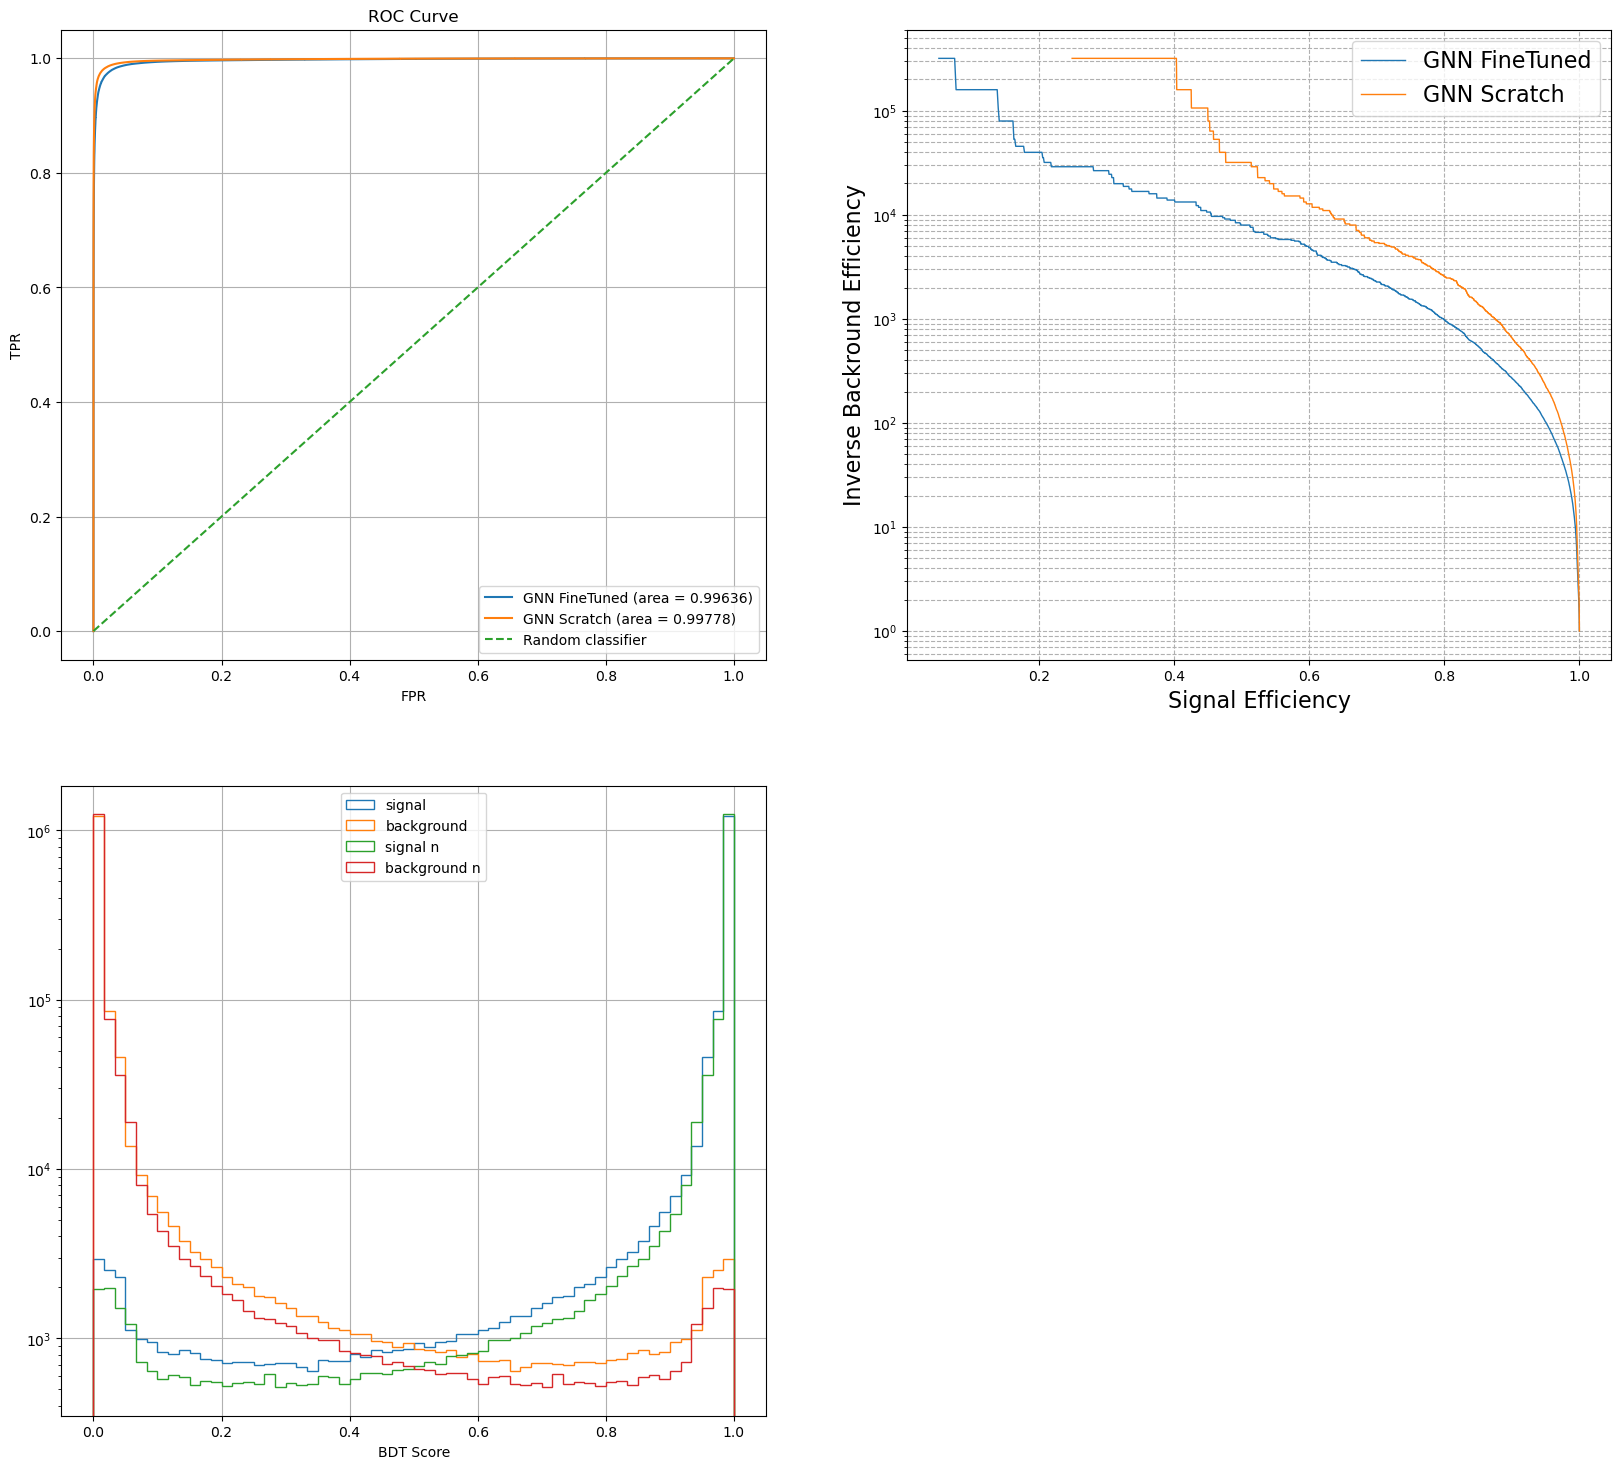

In [5]:
plt.figure(figsize=(20, 18))
plt.subplot(221)
plt.plot(fpr_w, tpr_w, label='GNN FineTuned (area = {:.5f})'.format(auc_w))
plt.plot(fpr_n, tpr_n, label='GNN Scratch (area = {:.5f})'.format(auc_n))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(tpr_w, 1/fpr_w, lw=1, label='GNN FineTuned')
plt.plot(tpr_n, 1/fpr_n, lw=1, label='GNN Scratch')
plt.xlabel('Signal Efficiency', fontsize=16)
plt.ylabel('Inverse Backround Efficiency', fontsize=16)
plt.yscale('log')
plt.legend(prop={'size': 16})
plt.grid(True, which="both", ls="--")

plt.subplot(223)
plt.hist(data['pred'][data['y']==1], bins=60, label='signal', histtype='step')
plt.hist(data['pred'][data['y']==0], bins=60, label='background', histtype='step')
plt.hist(data_n['pred'][data_n['y']==1], bins=60, label='signal n', histtype='step')
plt.hist(data_n['pred'][data_n['y']==0], bins=60, label='background n', histtype='step')
plt.xlabel('BDT Score')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()